## GSAT trend patterns

In [1]:
# In[1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# %%
# define function
import src.SAT_function as data_process
import src.Data_Preprocess as preprocess

In [2]:
import src.slurm_cluster as scluster
client, scluster = scluster.init_dask_slurm_cluster()

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /scratch/m/m301036/dask_logs//dask-worker-%J.err
#SBATCH -o /scratch/m/m301036/dask_logs//dask-worker-%J.out
#SBATCH -p compute
#SBATCH -A mh0033
#SBATCH -n 1
#SBATCH --cpus-per-task=64
#SBATCH --mem=256G
#SBATCH -t 01:00:00

/home/m/m301036/.conda/envs/mykernel/bin/python -m distributed.cli.dask_worker tcp://10.128.2.77:34741 --name dummy-name --nthreads 1 --memory-limit 4.00GiB --nworkers 64 --nanny --death-timeout 60 --local-directory /scratch/m/m301036/dask_temp/ --interface ib0



In [3]:
def func_mk(x):
    """
    Mann-Kendall test for trend
    """
    results = data_process.mk_test(x)
    slope = results[0]
    p_val = results[1]
    return slope, p_val
 

### loaded the separated data from models

In [4]:
dir1 ='/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Figure2/CanESM5/'
CanESM5_forced = xr.open_mfdataset(dir1 + 'GSAT_CanESM5_Forced_anomalies_1850_2022.nc',chunks={'run': 1})
CanESM5_internal = xr.open_mfdataset(dir1 + 'GSAT_CanESM5_Internal_Variability_anomalies_1850_2022.nc', chunks={'run': 1})

In [5]:
CanESM5_internal

<xarray.Dataset> Size: 1GB
Dimensions:  (lon: 180, lat: 90, year: 173, run: 50)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * year     (year) int64 1kB 1850 1851 1852 1853 1854 ... 2019 2020 2021 2022
  * run      (run) int64 400B 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    height   float64 8B ...
Data variables:
    tas      (run, year, lat, lon) float64 1GB dask.array<chunksize=(1, 173, 90, 180), meta=np.ndarray>

In [6]:
CanESM5_forced = CanESM5_forced.rename({'__xarray_dataarray_variable__':'tas'})

In [7]:
CanESM5_forced

<xarray.Dataset> Size: 1GB
Dimensions:  (year: 173, run: 50, lat: 90, lon: 180)
Coordinates:
  * year     (year) int64 1kB 1850 1851 1852 1853 1854 ... 2019 2020 2021 2022
    height   float64 8B ...
  * run      (run) int64 400B 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
Data variables:
    tas      (run, year, lat, lon) float64 1GB dask.array<chunksize=(1, 173, 90, 180), meta=np.ndarray>

### Calculate the trend on 10-73yrs length with end year anchoring at 2022

In [8]:
import pandas as pd
import numpy as np

start_year = 1950
end_year = 2022
min_length = 10

In [9]:
years = np.arange(start_year, end_year + 1)

# Prepare a dictionary to hold the trend DataArrays for each period
trend_data = {}
p_value_data = {}

for begin_year in range(start_year, end_year - min_length+2):
    # Select the data from the start year to the last year
    time_slice = CanESM5_forced.sel(year=slice(begin_year, end_year))
    
    # Calculate the trend for each grid cell
    trend, p_values = xr.apply_ufunc(
        func_mk,   # Pass the appropriate years
        time_slice,
        input_core_dims=[["year"]],
        output_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float],
        dask_gufunc_kwargs={'allow_rechunk': True}
    )
    period_key = f'{begin_year}-{end_year}'
    trend_data[period_key] = trend
    p_value_data[period_key] = p_values

In [10]:
trend_data

{'1950-2022': <xarray.Dataset> Size: 6MB
 Dimensions:  (run: 50, lat: 90, lon: 180)
 Coordinates:
     height   float64 8B ...
   * run      (run) int64 400B 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
   * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
 Data variables:
     tas      (run, lat, lon) float64 6MB dask.array<chunksize=(1, 90, 180), meta=np.ndarray>,
 '1951-2022': <xarray.Dataset> Size: 6MB
 Dimensions:  (run: 50, lat: 90, lon: 180)
 Coordinates:
     height   float64 8B ...
   * run      (run) int64 400B 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
   * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
 Data variables:
     tas      (run, lat, lon) float64 6MB dask.array<chunksize=(1, 90, 180), meta=np.ndarray>,
 '1952-2022': <xarray.Dataset> Size: 6MB

In [11]:
# Convert dictionaries to xarray DataArray for saving
trend_da = xr.concat(trend_data.values(), dim=pd.Index(trend_data, name='period'))


In [12]:
p_value_da = xr.concat(p_value_data.values(), dim=pd.Index(p_value_data, name='period'))

In [13]:
trend_da['period']

<xarray.DataArray 'period' (period: 64)> Size: 512B
array(['1950-2022', '1951-2022', '1952-2022', '1953-2022', '1954-2022',
       '1955-2022', '1956-2022', '1957-2022', '1958-2022', '1959-2022',
       '1960-2022', '1961-2022', '1962-2022', '1963-2022', '1964-2022',
       '1965-2022', '1966-2022', '1967-2022', '1968-2022', '1969-2022',
       '1970-2022', '1971-2022', '1972-2022', '1973-2022', '1974-2022',
       '1975-2022', '1976-2022', '1977-2022', '1978-2022', '1979-2022',
       '1980-2022', '1981-2022', '1982-2022', '1983-2022', '1984-2022',
       '1985-2022', '1986-2022', '1987-2022', '1988-2022', '1989-2022',
       '1990-2022', '1991-2022', '1992-2022', '1993-2022', '1994-2022',
       '1995-2022', '1996-2022', '1997-2022', '1998-2022', '1999-2022',
       '2000-2022', '2001-2022', '2002-2022', '2003-2022', '2004-2022',
       '2005-2022', '2006-2022', '2007-2022', '2008-2022', '2009-2022',
       '2010-2022', '2011-2022', '2012-2022', '2013-2022'], dtype=object)
Coordinates:
    height   float64 8B ...
  * period   (period) object 512B '1950-2022' '1951-2022' ... '2013-2022'

In [14]:
trend_da.sel(period='1950-2022')

<xarray.Dataset> Size: 6MB
Dimensions:  (run: 50, lat: 90, lon: 180)
Coordinates:
    height   float64 8B ...
  * run      (run) int64 400B 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    period   <U9 36B '1950-2022'
Data variables:
    tas      (run, lat, lon) float64 6MB dask.array<chunksize=(1, 90, 180), meta=np.ndarray>

In [ ]:
# trend_annual_np = {}
# pvalue_annual_np = {}

# for i in trend_data.keys():
#     trend_annual_np[i] = trend_data[i].values
#     pvalue_annual_np[i] = p_value_data[i].values

In [ ]:
# trend_annual_da = {}
# pvalue_annual_da = {}

# for interval, data in trend_annual_np.items():
#     trend_annual_da[interval] = xr.DataArray(data, dims=["run","lat", "lon"], coords={"run": CanESM5_forced_data_dict[interval].run, 
#     "lat": CanESM5_forced_data_dict[interval].lat, "lon": CanESM5_forced_data_dict[interval].lon})
# for interval, data in pvalue_annual_np.items():
#     pvalue_annual_da[interval] = xr.DataArray(data, dims=["run","lat", "lon"], coords={"run": CanESM5_forced_data_dict[interval].run, 
#     "lat": CanESM5_forced_data_dict[interval].lat, "lon": CanESM5_forced_data_dict[interval].lon})

In [15]:
# out put the forced trend and pvalue
dir_out ='/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/LE_evaluation/Fig3_CanESM5/output/'

trend_da.to_netcdf(dir_out + 'CanESM5_forced_segmented_trend.nc')
# p_value_xr.to_netcdf(dir_out + 'CanESM5_forced_segmented_pvalue.nc')

In [17]:
trend_da

<xarray.Dataset> Size: 415MB
Dimensions:  (period: 64, run: 50, lat: 90, lon: 180)
Coordinates:
    height   float64 8B ...
  * run      (run) int64 400B 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * period   (period) object 512B '1950-2022' '1951-2022' ... '2013-2022'
Data variables:
    tas      (period, run, lat, lon) float64 415MB dask.array<chunksize=(1, 1, 90, 180), meta=np.ndarray>

### Plotting with the Robinson Projections

In [18]:
plt.rcParams['figure.figsize'] = (8, 10)
plt.rcParams['font.size'] = 16
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.right'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['savefig.transparent'] = True # save the figure with a transparent background
x = np.arange(1850, 2015, 1)

In [19]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm, ListedColormap

In [20]:
def plot_trend(trend_data, lats, lons, levels=None, extend=None, cmap=None, title="", ax=None, show_xticks=False, show_yticks=False):
    """
    Plot the trend spatial pattern using Robinson projection with significance overlaid.

    Parameters:
    - trend_data: 2D numpy array with the trend values.
    - lats, lons: 1D arrays of latitudes and longitudes.
    - p_values: 2D array with p-values for each grid point.
    - GMST_p_values: 2D array with GMST p-values for each grid point.
    - title: Title for the plot.
    - ax: Existing axis to plot on. If None, a new axis will be created.
    - show_xticks, show_yticks: Boolean flags to show x and y axis ticks.
    
    Returns:
    - contour_obj: The contour object from the plot.
    """
    # Create a new figure/axis if none is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.Robinson()})
        ax.set_global()

    # Determine significance mask (where p-values are less than 0.05)
    # insignificance_mask = p_values >= 0.10
    # Plotting
    # contour_obj = ax.pcolormesh(lons, lats, trend_data,  cmap='RdBu_r',vmin=-5.0, vmax=5.0, transform=ccrs.PlateCarree(central_longitude=180), shading='auto')
    contour_obj = ax.contourf(lons, lats, trend_data, levels=levels, extend=extend, cmap=cmap, transform=ccrs.PlateCarree(central_longitude=0))

    # Plot significance masks with different hatches
    # ax.contourf(lons, lats, insignificance_mask, levels=[0.0, 0.10, 1.5],hatches=[None,'///'], colors='none', transform=ccrs.PlateCarree())

    ax.coastlines(resolution='110m')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      colors='gray', alpha=0.5, linestyle='--', linewidth=0.5)

    # Disable labels on the top and right of the plot
    gl.top_labels = False
    gl.right_labels = False

    # Enable labels on the bottom and left of the plot
    gl.bottom_labels = show_xticks
    gl.left_labels = show_yticks
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    
    if show_xticks:
        gl.bottom_labels = True
    if show_yticks:
        gl.left_labels = True
    
    ax.set_title(title, loc='center', fontsize=18, pad=5.0)

    return contour_obj

In [21]:
def plot_trend_with_significance(trend_data, lats, lons, p_values, GMST_p_values=None, levels=None, extend=None, cmap=None, title="", ax=None, show_xticks=False, show_yticks=False):
    """
    Plot the trend spatial pattern using Robinson projection with significance overlaid.

    Parameters:
    - trend_data: 2D numpy array with the trend values.
    - lats, lons: 1D arrays of latitudes and longitudes.
    - p_values: 2D array with p-values for each grid point.
    - GMST_p_values: 2D array with GMST p-values for each grid point.
    - title: Title for the plot.
    - ax: Existing axis to plot on. If None, a new axis will be created.
    - show_xticks, show_yticks: Boolean flags to show x and y axis ticks.
    
    Returns:
    - contour_obj: The contour object from the plot.
    """
    # Create a new figure/axis if none is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.Robinson()})
        ax.set_global()

    # Determine significance mask (where p-values are less than 0.05)
    insignificance_mask = p_values >= 0.10
    # Plotting
    # contour_obj = ax.pcolormesh(lons, lats, trend_data,  cmap='RdBu_r',vmin=-5.0, vmax=5.0, transform=ccrs.PlateCarree(central_longitude=180), shading='auto')
    contour_obj = ax.contourf(lons, lats, trend_data, levels=levels, extend=extend, cmap=cmap, transform=ccrs.PlateCarree(central_longitude=0))

    # Plot significance masks with different hatches
    ax.contourf(lons, lats, insignificance_mask, levels=[0.0, 0.10, 1.5],hatches=[None,'///'], colors='none', transform=ccrs.PlateCarree())

    ax.coastlines(resolution='110m')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      colors='gray', alpha=0.5, linestyle='--', linewidth=0.5)

    # Disable labels on the top and right of the plot
    gl.top_labels = False
    gl.right_labels = False

    # Enable labels on the bottom and left of the plot
    gl.bottom_labels = show_xticks
    gl.left_labels = show_yticks
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    
    if show_xticks:
        gl.bottom_labels = True
    if show_yticks:
        gl.left_labels = True
    
    ax.set_title(title, loc='center', fontsize=18, pad=5.0)

    return contour_obj

In [22]:
dir_input = '/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/LE_evaluation/Fig3_CanESM5/output/'
trend_da = xr.open_mfdataset(dir_input + 'CanESM5_forced_segmented_trend.nc', chunks={'run': 1})

In [23]:
trend_da

<xarray.Dataset> Size: 415MB
Dimensions:  (period: 64, run: 50, lat: 90, lon: 180)
Coordinates:
    height   float64 8B ...
  * run      (run) int64 400B 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * period   (period) <U9 2kB '1950-2022' '1951-2022' ... '2013-2022'
Data variables:
    tas      (period, run, lat, lon) float64 415MB dask.array<chunksize=(64, 1, 90, 180), meta=np.ndarray>

In [24]:
lat = trend_da['lat']
lon = trend_da['lon']

In [25]:
lat

<xarray.DataArray 'lat' (lat: 90)> Size: 720B
array([-89., -87., -85., -83., -81., -79., -77., -75., -73., -71., -69., -67.,
       -65., -63., -61., -59., -57., -55., -53., -51., -49., -47., -45., -43.,
       -41., -39., -37., -35., -33., -31., -29., -27., -25., -23., -21., -19.,
       -17., -15., -13., -11.,  -9.,  -7.,  -5.,  -3.,  -1.,   1.,   3.,   5.,
         7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,  23.,  25.,  27.,  29.,
        31.,  33.,  35.,  37.,  39.,  41.,  43.,  45.,  47.,  49.,  51.,  53.,
        55.,  57.,  59.,  61.,  63.,  65.,  67.,  69.,  71.,  73.,  75.,  77.,
        79.,  81.,  83.,  85.,  87.,  89.])
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Attributes:
    long_name:      latitude
    axis:           Y
    standard_name:  latitude
    units:          degrees_north

In [26]:
# define an asymmetric colormap
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.util as cutil
import seaborn as sns
import matplotlib.colors as mcolors
import palettable

In [27]:
# title is from realization 1 to realization 21
titles = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 
          'r11', 'r12', 'r13', 'r14', 'r15', 'r16', 'r17', 'r18', 'r19',
          'r20', 'r21', 'r22', 'r23', 'r24', 'r25', 'r26', 'r27', 'r28',
          'r29', 'r30', 'r31', 'r32', 'r33', 'r34', 'r35', 'r36', 'r37',
          'r38', 'r39', 'r40', 'r41', 'r42', 'r43', 'r44', 'r45', 'r46',
          'r47', 'r48', 'r49', 'r50']
trend_annual_data = trend_da.sel(period='2013-2022')*10.0

levels = np.arange(-0.6, 0.65, 0.05)
extend = 'both'

In [28]:
type(trend_annual_data)

xarray.core.dataset.Dataset

In [29]:
trend_annual_data['tas']

<xarray.DataArray 'tas' (run: 50, lat: 90, lon: 180)> Size: 6MB
dask.array<mul, shape=(50, 90, 180), dtype=float64, chunksize=(1, 90, 180), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * run      (run) int64 400B 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    period   <U9 36B '2013-2022'

In [30]:
p_value_data = p_value_da.sel(period='2013-2022')

In [31]:
p_value_data

<xarray.Dataset> Size: 6MB
Dimensions:  (run: 50, lat: 90, lon: 180)
Coordinates:
    height   float64 8B ...
  * run      (run) int64 400B 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    period   <U9 36B '2013-2022'
Data variables:
    tas      (run, lat, lon) float64 6MB dask.array<chunksize=(1, 90, 180), meta=np.ndarray>

In [32]:
print(trend_annual_data.dims)
# print(pvalue_annual_data.dims)

FrozenMappingWarningOnValuesAccess({'run': 50, 'lat': 90, 'lon': 180})


In [33]:
# check the min and max value of the trend
print(trend_annual_data.min().values)
print(trend_annual_data.max().values)

<bound method Mapping.values of <xarray.Dataset> Size: 52B
Dimensions:  ()
Coordinates:
    height   float64 8B ...
    period   <U9 36B '2013-2022'
Data variables:
    tas      float64 8B dask.array<chunksize=(), meta=np.ndarray>>
<bound method Mapping.values of <xarray.Dataset> Size: 52B
Dimensions:  ()
Coordinates:
    height   float64 8B ...
    period   <U9 36B '2013-2022'
Data variables:
    tas      float64 8B dask.array<chunksize=(), meta=np.ndarray>>


### Plotting

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/tmp/ipykernel_1971957/1392268772.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


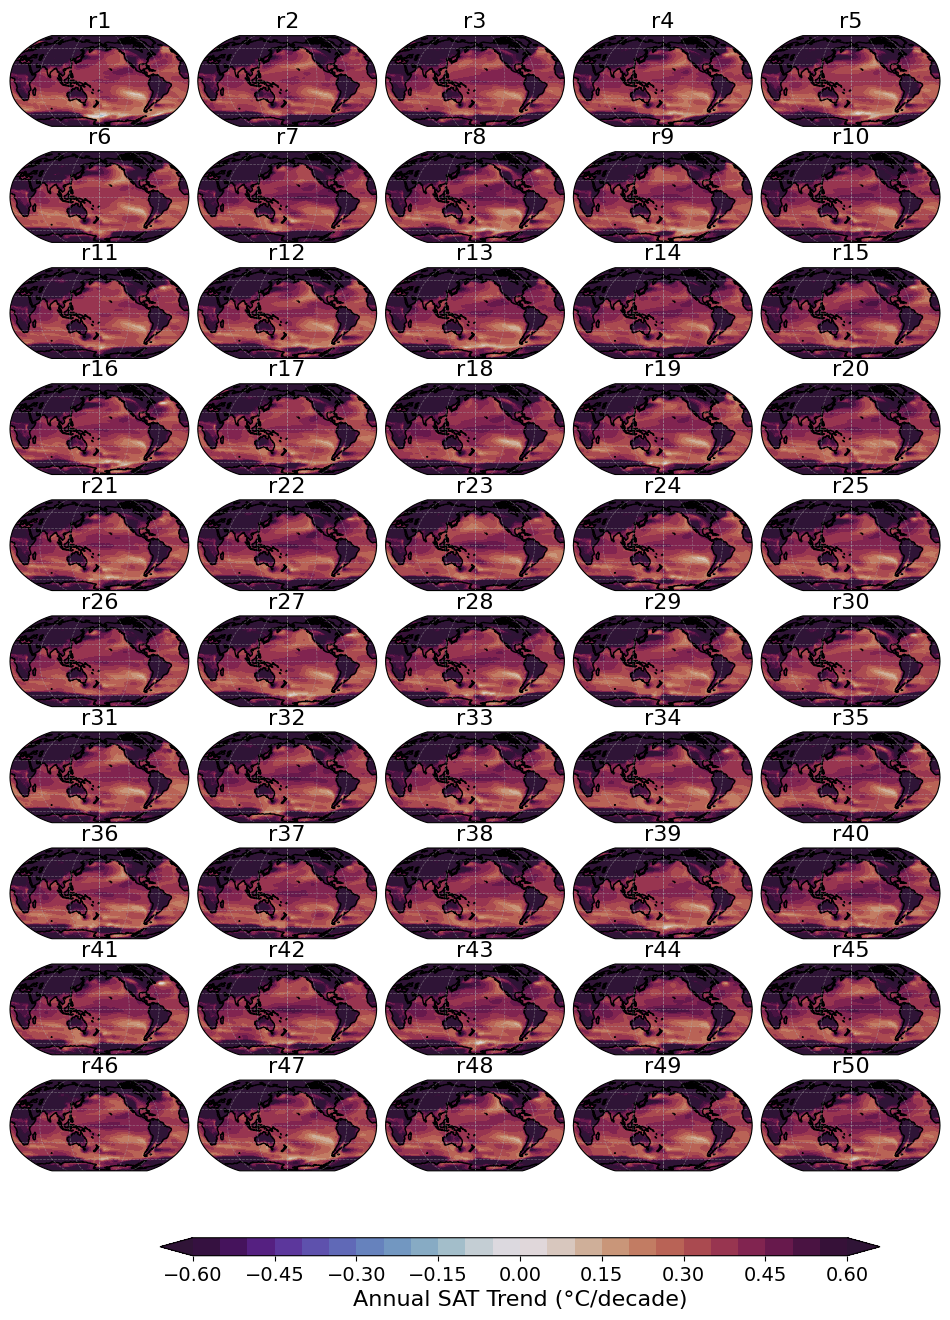

In [34]:
# Plot the trend patterns 
def plot_data(ax, title):
    run_number = int(title.lstrip('r')) # Strip 'r' and convert to integer if necessary
    print(run_number)
    
    trend_data = trend_annual_data['tas'].sel({'run': run_number}) 
    # p_values = p_value_data['tas'].sel({'run': run_number})
    
    trend_data_with_cyclic, lon_cyclic = cutil.add_cyclic_point(trend_data, coord=lon)
    # p_values_with_cyclic, _ = cutil.add_cyclic_point(p_values, coord=lon)
    
    ax.set_global()
    
    # Assuming plot_trend_with_significance is defined correctly and returns a contour object
    contour_obj = plot_trend(trend_data_with_cyclic, lat, lon_cyclic,
            levels=levels, extend=extend,
            cmap='twilight_shifted', title=" ",
            ax=ax, 
            show_xticks=False, 
            show_yticks=False)
    ax.text(0.5, 1.15, title, ha='center', va='center', transform=ax.transAxes)  # Adjusted to use transform
    ax.set_xticks([])
    ax.set_yticks([])
    return contour_obj

# Prepare for the loop
fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(10, 5, wspace=0.05, hspace=0.05)

# Loop through and create subplots
for i, title in enumerate(titles):
    ax = fig.add_subplot(gs[i // 5, i % 5], projection=ccrs.Robinson(180))
    contour_obj=plot_data(ax, title)
    if i == 0:  # Arbitrarily choose the first plot's contour_obj for the colorbar
        contour_obj_for_cbar = contour_obj
        
# Assuming contour_obj is defined and consistent across plots
# Add horizontal colorbar
cbar_ax = fig.add_axes([0.25, 0.06, 0.6, 0.012])  # Adjust these values as needed
cbar = plt.colorbar(contour_obj, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Annual SAT Trend (°C/decade)', fontsize=16)

plt.tight_layout()
fig.savefig('CanESM5-[2013-2022]-10year-forced-trend.png', dpi=300, bbox_inches='tight')
plt.show()

### Input the ensemble mean trend patterns; then calculate the pattern correlation

In [ ]:
# Input the 10-year, 30-year and 60-year ensemble mean SAT trend data
# dir_input = '/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Supp_Figure1_Forced/data/Smiles_ensemble/'

# CanESM5_10yr_trend   = xr.open_dataset(dir_input + 'CanESM5_annual_forced_10yr_trend.nc')
# CanESM5_30yr_trend   = xr.open_dataset(dir_input + 'CanESM5_annual_forced_30yr_trend.nc')
# CanESM5_60yr_trend   = xr.open_dataset(dir_input + 'CanESM5_annual_forced_60yr_trend.nc')

In [ ]:
dir_input = '/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Supp_Figure1_Forced/data/CanESM5_Single/'

CanESM5_10yr_trend   = xr.open_dataset(dir_input + 'CanESM5_annual_10yr_ensemble_mean_trend.nc')
CanESM5_30yr_trend   = xr.open_dataset(dir_input + 'CanESM5_annual_30yr_ensemble_mean_trend.nc')
CanESM5_60yr_trend   = xr.open_dataset(dir_input + 'CanESM5_annual_60yr_ensemble_mean_trend.nc')

In [ ]:
CanESM5_10yr_trend = CanESM5_10yr_trend.rename({'__xarray_dataarray_variable__':'tas'})
CanESM5_30yr_trend = CanESM5_30yr_trend.rename({'__xarray_dataarray_variable__':'tas'})
CanESM5_60yr_trend = CanESM5_60yr_trend.rename({'__xarray_dataarray_variable__':'tas'})

In [ ]:
# pattern correlation betwenn observed forced pattern vs. Model simulated forced pattern
import scipy.stats as stats
# 10yr forced trend in each realization .vs. CanESM5 ensemble trend CanESM5_10yr_trend
CanESM5_forced_10yr_trend = trend_annual_da['10yr']
CanESM5_forced_30yr_trend = trend_annual_da['30yr']
CanESM5_forced_60yr_trend = trend_annual_da['60yr']

CanESM5_unforced_10yr_trend = unforced_trend_da['10yr']
CanESM5_unforced_30yr_trend = unforced_trend_da['30yr']
CanESM5_unforced_60yr_trend = unforced_trend_da['60yr']

# Pattern correlations calculation
trend_pattern_correlation_10yr = []
for i in range(len(trend_annual_da['10yr'].run)):
    trend_pattern_correlation_10yr.append(stats.pearsonr(CanESM5_forced_10yr_trend.isel(run=i).values.flatten(), CanESM5_10yr_trend['tas'].values.flatten())[0])

trend_pattern_correlation_30yr = []
for i in range(len(trend_annual_da['30yr'].run)):
    trend_pattern_correlation_30yr.append(stats.pearsonr(CanESM5_forced_30yr_trend.isel(run=i).values.flatten(), CanESM5_30yr_trend['tas'].values.flatten())[0])

trend_pattern_correlation_60yr = []
for i in range(len(trend_annual_da['60yr'].run)):
    trend_pattern_correlation_60yr.append(stats.pearsonr(CanESM5_forced_60yr_trend.isel(run=i).values.flatten(), CanESM5_60yr_trend['tas'].values.flatten())[0])
    

In [ ]:
trend_pattern_correlation_10yr

In [ ]:
with open('pattern_correlations_vs_mean_of_trend.txt', 'w') as file:
    file.write('10-year Trend Pattern Correlations:\n')
    for correlation in trend_pattern_correlation_10yr:
        file.write(f"{correlation}\n")

    file.write('\n30-year Trend Pattern Correlations:\n')
    for correlation in trend_pattern_correlation_30yr:
        file.write(f"{correlation}\n")

    file.write('\n60-year Trend Pattern Correlations:\n')
    for correlation in trend_pattern_correlation_60yr:
        file.write(f"{correlation}\n")

In [ ]:
# save the pattern correlation into text file
# Save to a text file
with open('pattern_correlations.txt', 'w') as file:
    file.write('10-year Trend Pattern Correlations:\n')
    for correlation in trend_pattern_correlation_10yr:
        file.write(f"{correlation}\n")

    file.write('\n30-year Trend Pattern Correlations:\n')
    for correlation in trend_pattern_correlation_30yr:
        file.write(f"{correlation}\n")

    file.write('\n60-year Trend Pattern Correlations:\n')
    for correlation in trend_pattern_correlation_60yr:
        file.write(f"{correlation}\n")

In [ ]:
# Input the observational forced and unforced trend wrt. CanESM5-CM6A-LR
dir_obs_CanESM5 = '/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Figure2/data/'

Obs_CanESM5_forced_10yr_trend = xr.open_dataset(dir_obs_CanESM5 + 'HadCRUT5_annual_forced_10yr_trend_CanESM5.nc')
Obs_CanESM5_forced_30yr_trend = xr.open_dataset(dir_obs_CanESM5 + 'HadCRUT5_annual_forced_30yr_trend_CanESM5.nc')
Obs_CanESM5_forced_60yr_trend = xr.open_dataset(dir_obs_CanESM5 + 'HadCRUT5_annual_forced_60yr_trend_CanESM5.nc')

Obs_CanESM5_unforced_10yr_trend = xr.open_dataset(dir_obs_CanESM5 + 'HadCRUT5_annual_internal_10yr_trend_CanESM5.nc')
Obs_CanESM5_unforced_30yr_trend = xr.open_dataset(dir_obs_CanESM5 + 'HadCRUT5_annual_internal_30yr_trend_CanESM5.nc')
Obs_CanESM5_unforced_60yr_trend = xr.open_dataset(dir_obs_CanESM5 + 'HadCRUT5_annual_internal_60yr_trend_CanESM5.nc')

In [ ]:
Obs_CanESM5_unforced_10yr_trend

In [ ]:
Obs_CanESM5_forced_10yr_trend = Obs_CanESM5_forced_10yr_trend.rename({'__xarray_dataarray_variable__':'tas'})
Obs_CanESM5_forced_30yr_trend = Obs_CanESM5_forced_30yr_trend.rename({'__xarray_dataarray_variable__':'tas'})
Obs_CanESM5_forced_60yr_trend = Obs_CanESM5_forced_60yr_trend.rename({'__xarray_dataarray_variable__':'tas'})

Obs_CanESM5_unforced_10yr_trend = Obs_CanESM5_unforced_10yr_trend.rename({'__xarray_dataarray_variable__':'tas'})
Obs_CanESM5_unforced_30yr_trend = Obs_CanESM5_unforced_30yr_trend.rename({'__xarray_dataarray_variable__':'tas'})
Obs_CanESM5_unforced_60yr_trend = Obs_CanESM5_unforced_60yr_trend.rename({'__xarray_dataarray_variable__':'tas'})

In [ ]:
# calculate the pattern correlation between observed and model's each realization simulated forced and unforced trend
OBS_trend_pattern_correlation_10yr = []
for i in range(len(trend_annual_da['10yr'].run)):
    print(i)
    OBS_trend_pattern_correlation_10yr.append(stats.pearsonr(CanESM5_forced_10yr_trend.isel(run=i).values.flatten(), Obs_CanESM5_forced_10yr_trend['tas'].values.flatten())[0])

OBS_trend_pattern_correlation_30yr = []
for i in range(len(trend_annual_da['30yr'].run)):
    print(i)
    OBS_trend_pattern_correlation_30yr.append(stats.pearsonr(CanESM5_forced_30yr_trend.isel(run=i).values.flatten(), Obs_CanESM5_forced_30yr_trend['tas'].values.flatten())[0])

OBS_trend_pattern_correlation_60yr = []
for i in range(len(trend_annual_da['60yr'].run)):
    print(i)
    OBS_trend_pattern_correlation_60yr.append(stats.pearsonr(CanESM5_forced_60yr_trend.isel(run=i).values.flatten(), Obs_CanESM5_forced_60yr_trend['tas'].values.flatten())[0])

In [ ]:
# Save to a text file
with open('obsForced_CanESM5forced_pattern_correlations.txt', 'w') as file:
    file.write('10-year Trend Pattern Correlations:\n')
    for correlation in OBS_trend_pattern_correlation_10yr:
        file.write(f"{correlation}\n")

    file.write('\n30-year Trend Pattern Correlations:\n')
    for correlation in OBS_trend_pattern_correlation_30yr:
        file.write(f"{correlation}\n")

    file.write('\n60-year Trend Pattern Correlations:\n')
    for correlation in OBS_trend_pattern_correlation_60yr:
        file.write(f"{correlation}\n")

In [ ]:
OBS_trend_pattern_correlation_10yr

In [ ]:
OBS_unforced_trend_pattern_correlation_10yr = []
for i in range(len(trend_annual_da['10yr'].run)):
    OBS_unforced_trend_pattern_correlation_10yr.append(stats.pearsonr(CanESM5_unforced_10yr_trend.isel(run=i).values.flatten(), Obs_CanESM5_unforced_10yr_trend['tas'].values.flatten())[0])
    
OBS_unforced_trend_pattern_correlation_30yr = []
for i in range(len(trend_annual_da['30yr'].run)):
    OBS_unforced_trend_pattern_correlation_30yr.append(stats.pearsonr(CanESM5_unforced_30yr_trend.isel(run=i).values.flatten(), Obs_CanESM5_unforced_30yr_trend['tas'].values.flatten())[0])
    
OBS_unforced_trend_pattern_correlation_60yr = []
for i in range(len(trend_annual_da['60yr'].run)):
    OBS_unforced_trend_pattern_correlation_60yr.append(stats.pearsonr(CanESM5_unforced_60yr_trend.isel(run=i).values.flatten(), Obs_CanESM5_unforced_60yr_trend['tas'].values.flatten())[0])

In [ ]:
OBS_unforced_trend_pattern_correlation_30yr

In [ ]:
# Save to a text file
with open('obsUnforced_CanESM5unforced_pattern_correlations.txt', 'w') as file:
    file.write('10-year Trend Pattern Correlations:\n')
    for correlation in OBS_unforced_trend_pattern_correlation_10yr:
        file.write(f"{correlation}\n")

    file.write('\n30-year Trend Pattern Correlations:\n')
    for correlation in OBS_unforced_trend_pattern_correlation_30yr:
        file.write(f"{correlation}\n")

    file.write('\n60-year Trend Pattern Correlations:\n')
    for correlation in OBS_unforced_trend_pattern_correlation_60yr:
        file.write(f"{correlation}\n")

In [ ]:
client.close()
scluster.close()